In [1]:
import pandas as pd 
from selenium import webdriver
import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Import ARIMA model.
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import requests
from bs4 import BeautifulSoup

## Functions

#### Function to return game logs from season and amount of pages wanted (2019-20 and 50 pages, for example)

In [2]:
def nba_game_logs1(num_clicks):
    
    # Path to Driver 
    path = '/Users/willhanley/Desktop/chromedriver 3'
    driver = webdriver.Chrome(executable_path=path)
    
    # URL
    url = 'https://www.nba.com/stats/players/boxscores/?Season=2020-21&SeasonType=Regular%20Season'
    driver.get(url)
    
    # location of table, button to click to next page 
    table = driver.find_element_by_class_name('nba-stat-table__overflow').text.split('\n')
    next_page = driver.find_elements_by_xpath('/html/body/main/div/div/div[2]/div/div/nba-stat-table/div[3]/div/div/a[2]')

    # empty lists to be appended to 
    player_names = []
    player_stats = []
    
    # Loop through num_clicks times
    for _ in range(num_clicks):
        
        # Define the table we are scraping from 
        table = driver.find_element_by_class_name('nba-stat-table__overflow').text.split('\n')
        
        # append to player_names and player_stats lists
        for num, info in enumerate(table):
            if num == 0:
                continue
            else:
                if num % 2 == 1:
                    player_names.append(info)
                if num % 2 == 0:
                    player_stats.append([i for i in info.split(' ')])
                
        # Click to next page            
        driver.execute_script("arguments[0].click();", next_page[0])
        
        # Pause 5 seconds 
        time.sleep(4)
 
    # Return dataframe made from player_names and player_stats
    return pd.DataFrame({'Player': player_names,
                  'Team': [i[0] for i in player_stats],
                  'Match-up': [i[2]+i[3] for i in player_stats],
                  'Date': [i[4] for i in player_stats],
                  'W/L': [i[5] for i in player_stats],
                  'Min': [i[6] for i in player_stats],
                  'Pts': [i[7] for i in player_stats],
                  'FGM': [i[8] for i in player_stats],
                  'FGA': [i[9] for i in player_stats],
                  'FG%': [i[10] for i in player_stats],
                  '3PM': [i[11] for i in player_stats],
                  '3PA': [i[12] for i in player_stats],
                  '3P%': [i[13] for i in player_stats],
                  'FTM': [i[14] for i in player_stats],
                  'FTA': [i[15] for i in player_stats],
                  'FT%': [i[16] for i in player_stats],
                  'OREB': [i[17] for i in player_stats],
                  'DREB': [i[18] for i in player_stats],
                  'REB': [i[19] for i in player_stats],
                  'AST': [i[20] for i in player_stats],
                  'STL': [i[21] for i in player_stats],
                  'BLK': [i[22] for i in player_stats],
                  'TOV': [i[23] for i in player_stats],
                  'PF': [i[24] for i in player_stats],
                  '+/-': [i[25] for i in player_stats]})

#### Functions for if players had a double-double or a triple-double

In [3]:
# Function if player has a double double 

def double_double(row):
    val = 0
    if (row['Pts'] >= 10) & (row['AST'] >= 10) | \
    (row['Pts'] >=10) & (row['REB'] >= 10) | (row['AST'] >=10) & (row['REB'] >= 10):
        val += 1
    return val

# Function if player has a triple double 

def triple_double(row):
    val = 0
    if (row['Pts'] >= 10) & (row['AST'] >= 10) & (row['REB'] >=10) | \
    (row['Pts'] >=10) & (row['AST'] >= 10) & (row['STL'] >= 10) | \
    (row['Pts'] >=10) & (row['REB'] >= 10) & (row['BLK'] >= 10) | \
    (row['Pts'] >=10) & (row['AST'] >= 10) & (row['BLK'] >= 10):
        val += 1
    return val

#### Function to return team defense statistics from season input (2019-20, for example)

In [4]:
def nba_defense(season_year):
    
    # Path to Driver 
    path = '/Users/willhanley/Desktop/chromedriver 3'
    driver = webdriver.Chrome(executable_path=path)
    
    # URL
    url = f'https://www.nba.com/stats/teams/defense/?sort=W&dir=-1&Season={season_year}&SeasonType=Regular%20Season'
    driver.get(url)
    
    # location of table, button to click to next page 
    table = driver.find_element_by_class_name('nba-stat-table__overflow').text.split('\n')
    
    # empty lists to append to 
    teams = []
    team_stats = []
    
    # find locations of team names and team stats 
    for num, info in enumerate(table):
        if num > 8:
            if num % 3 == 0:
                teams.append(info)
            if (num -1) % 3 == 0:
                team_stats.append([i for i in info.split(' ')])

    # return dataframe 
    return pd.DataFrame({
        'Season': season_year,
        'Team': teams,
        'GP': [i[0] for i in team_stats],
        'W': [i[1] for i in team_stats],
        'L': [i[2] for i in team_stats],
        'MIN': [i[3] for i in team_stats],
        'DEF_RTG': [i[4] for i in team_stats],
        'DREB': [i[5] for i in team_stats],
        'DREB%': [i[6] for i in team_stats],
        'STL': [i[7] for i in team_stats],
        'BLK': [i[8] for i in team_stats],
        'OPP_PTS_off_TOV': [i[9] for i in team_stats],
        'OPP_PTS_2nd_CHANCE': [i[10] for i in team_stats],
        'OPP_PTS_FB': [i[11] for i in team_stats],
        'OPP_PTS_PAINT': [i[12] for i in team_stats]})

#### Function to find a list of the players that are playing tonight. 

In [1097]:
# Function to find a list of the players that are playing tonight

def playing_tonight():    
    url = 'https://www.sportsline.com/nba/expert-projections/simulation/'

    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find_all("table")[0]

    data = [[cell.text for cell in row.find_all(["th","td"])]
                            for row in table.find_all("tr")]
    df = pd.DataFrame(data)

    df.columns = df.iloc[0,:]
    df.drop(index=0,inplace=True)
    return df

players_playing_tonight_df = playing_tonight()

players_playing_tonight_df = players_playing_tonight_df[['PLAYER  ','POS  ']]

players_playing_tonight = list(players_playing_tonight_df['PLAYER  '])


#### Function to collect all DraftKing Salaries for players

In [1124]:
# Function to find DraftKing Salaries of all players playing tonight

def dk_salary():    
    url = 'https://www.fantasypros.com/daily-fantasy/nba/draftkings-salary-changes.php'

    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find_all("table")[0]

    data = [[cell.text for cell in row.find_all(["th","td"])]
                            for row in table.find_all("tr")]
    df = pd.DataFrame(data)

    df.columns = df.iloc[0,:]
    df.drop(index=0,inplace=True)
    return df

dk_salary = dk_salary()

dk_salary['Today'] = dk_salary['Today'].str.replace('$', '')
dk_salary['Today'] = dk_salary['Today'].str.replace(',', '_')
dk_salary['Today'] = dk_salary['Today'].astype(float)
dk_salary['Salary'] = dk_salary['Today']

dk_salary = dk_salary[['Player','Salary']]

dk_salary['Position'] = dk_salary['Player'].apply(lambda st: st[st.find("(")+1:st.find(")")])

dk_salary['Position'] = dk_salary['Position'].apply(lambda st:[st.split('- ',1)[-1]])

dk_salary['Player'] = dk_salary['Player'].str.replace(r"\(.*?\)","").str.strip()

dk_salary['Position'] = [','.join(map(str, l)) for l in dk_salary['Position']]

dk_salary['Position'].unique()


array(['SG/SF', 'C', 'PG', 'PF', 'SF/PF', 'PF/C', 'PG/SG', 'SG', 'SF',
       'PG/SF'], dtype=object)

## Update the current season to todays date and read in past data

In [7]:
# Web-scrape current season for updated information

twenty = nba_game_logs1(82)
twenty.head()

,Player,Team,Match-up,Date,W/L,Min,Pts,FGM,FGA,FG%,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
0,Cassius Stanley,IND,@LAC,01/17/2021,L,8,0,0,3,0.0,...,-,0,0,0,0,0,1,0,4,-4
1,Paul George,LAC,vs.IND,01/17/2021,W,34,20,7,11,63.6,...,100,0,7,7,4,1,0,4,2,16
2,Patrick Patterson,LAC,vs.IND,01/17/2021,W,18,10,3,6,50.0,...,50.0,0,0,0,1,1,0,2,2,21
3,Marcus Morris Sr.,LAC,vs.IND,01/17/2021,W,27,20,7,11,63.6,...,66.7,2,5,7,3,1,0,1,1,35
4,T.J. McConnell,IND,@LAC,01/17/2021,L,26,2,1,3,33.3,...,-,0,3,3,6,2,0,2,1,-18


#### Read in seasons 2016-17 to 2019-20

In [8]:
sixteen = pd.read_csv('data/2016=2017stats.csv')
seventeen = pd.read_csv('data/2017-2018stats.csv')
eighteen = pd.read_csv('data/2018-2019stats.csv')
nineteen = pd.read_csv('data/game_logs2019-2020.csv')
#twenty = pd.read_csv('data/20-21_game_logs.csv')

#### Feature Engineering and Concat all game logs together 

In [9]:
# Date column to datetime

sixteen['Date'] = pd.to_datetime(sixteen['Date'])
seventeen['Date'] = pd.to_datetime(seventeen['Date'])
eighteen['Date'] = pd.to_datetime(eighteen['Date'])
nineteen['Date'] = pd.to_datetime(nineteen['Date'])
twenty['Date'] = pd.to_datetime(twenty['Date'])

# Create Season column

sixteen['Season'] = '2016-17'
seventeen['Season'] = '2017-18'
eighteen['Season'] = '2018-19'
nineteen['Season'] = '2019-20'
twenty['Season'] = '2020-21'

# Concat 1 dataframe
frames = [sixteen,seventeen,eighteen,nineteen,twenty]
game_logs_all = pd.concat(frames)
game_logs_all.sort_index(inplace=True)

# Drop columns with percentages

game_logs_all.drop(columns=['FT%', '3P%', 'FG%'], inplace=True)

# Save numerical columns as ints

game_logs_all[['Min', 'Pts', 'FGM','FGA','3PM', '3PA', 'FTM', 'FTA', 'OREB',
       'DREB','REB','AST','STL','BLK','TOV','PF', '+/-']] = game_logs_all[['Min', 'Pts', 'FGM','FGA','3PM', '3PA', 'FTM', 'FTA', 'OREB',
       'DREB','REB','AST','STL','BLK','TOV','PF', '+/-']].astype(str).astype(int)

# Create Double double column
game_logs_all['dubdub'] = game_logs_all.apply(double_double, axis=1)

# Create Triple double column
game_logs_all['tripdub'] = game_logs_all.apply(triple_double, axis=1)

# Create Draft kings score column (based on draftkings formula)
game_logs_all['DraftKings'] = game_logs_all['Pts'] + .5*game_logs_all['3PM'] + 1.25*game_logs_all['REB'] + 1.5*game_logs_all['AST'] \
+ 2*game_logs_all['STL'] + 2*game_logs_all['BLK'] -.5*game_logs_all['TOV'] + 1.5*game_logs_all['dubdub'] + 3*game_logs_all['tripdub']

# Home or away column: 1 for away, 0 for home
game_logs_all['Home/Away'] = game_logs_all['Match-up'].str.contains('@').astype(int)

# Full names for 'Match-up'
game_logs_all['Match-up'] = game_logs_all['Match-up'].map({'vs.UTA': 'Utah Jazz', '@POR':'Portland Trailblazers',
                        '@GSW':'Golden State Warriors', 'vs.SAS':'San Antonio Spurs',
                        '@IND':'Indiana Pacers','vs.DAL':'Dallas Mavericks','vs.CHA':'Charlotte Hornets',
                        'vs.DET':'Detroit Pistons','@TOR':'Toronto Raptors','@MIL': 'Milwaukee Bucks',
                        '@MEM': 'Memphis Grizzlies','vs.MIN':'Minnesota Timberwolves','vs.DEN': 'Denver Nuggets',
                        '@NOP': 'New Orleans Pelicans','vs.MIA': 'Miami Heat','@LAL':'Los Angeles Lakers',
                        'vs.HOU':'Houston Rockets','@ORL':'Orlando Magic','@PHX':'Phoenix Suns','vs.SAC':'Sacramento Kings',
                        'vs.OKC':'Oklahoma City Thunder','@PHI':'Philadelphia 76ers','@BOS':'Boston Celtics',
                        'vs.BKN':'Brooklyn Nets','vs.WAS':'Washington Wizards','@ATL':'Atlanta Hawks',
                        '@SAC':'Sacramento Kings','vs.BOS':'Boston Celtics','@CHI':'Chicago Bulls',
                        'vs.LAC': 'LA Clippers','vs.CLE':'Cleveland Cavaliers','@DAL':'Dallas Mavericks',
                        'vs.PHX': 'Phoenix Suns','vs.GSW':'Golden State Warriors','@OKC':'Oklahoma City Thunder',
                        '@UTA':'Utah Jazz','vs.LAL':'Los Angeles Lakers','@MIA':'Miami Heat','vs.IND':'Indiana Pacers',
                        '@BKN':'Brooklyn Nets','vs.ORL':'Orlando Magic','@DET':'Detroit Pistons','vs.MEM':'Memphis Grizzlies',
                        '@CLE':'Cleveland Cavaliers','@CHA':'Charlotte Hornets','@DEN':'Denver Nuggets','vs.POR':'Portland Trailblazers',
                        'vs.NOP':'New Orleans Pelicans','@SAS':'San Antonio Spurs','vs.ATL':'Atlanta Hawks','@NYK':'New York Knicks',
                        'vs.MIL':'Milwaukee Bucks','@LAC':'LA Clippers','@HOU':'Houston Rockets','vs.CHI':'Chicago Bulls',
                        'vs.NYK':'New York Knicks','@MIN':'Minnesota Timberwolves','vs.PHI':'Philadelphia 76ers','@WAS':'Washington Wizards',
                        'vs.TOR':'Toronto Raptors'})

# Save as csv
game_logs_all.to_csv('data/game_logs_all.csv')


## Update current defensive statistics 

In [10]:
twenty_d = nba_defense('2020-21')
twenty_d.head()

,Season,Team,GP,W,L,MIN,DEF_RTG,DREB,DREB%,STL,BLK,OPP_PTS_off_TOV,OPP_PTS_2nd_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT
0,2020-21,Los Angeles Lakers,14,11,3,48.0,104.0,38.1,76.1,7.0,6.6,16.6,12.1,12.4,47.1
1,2020-21,LA Clippers,14,10,4,48.0,110.9,32.8,74.5,7.1,4.8,16.4,10.4,13.2,43.4
2,2020-21,Milwaukee Bucks,13,9,4,48.0,107.4,37.2,73.3,9.1,5.0,17.9,12.8,9.5,41.7
3,2020-21,Philadelphia 76ers,14,9,5,48.4,105.7,37.4,73.3,8.4,7.1,20.0,13.6,17.8,44.4
4,2020-21,Utah Jazz,13,9,4,48.0,106.5,38.2,73.9,5.7,5.8,17.1,11.6,12.1,47.7


#### Read in past defense statistics

In [87]:
sixteen_d = pd.read_csv('data/16-17_defense.csv')
seventeen_d = pd.read_csv('data/17-18_defense.csv')
eighteen_d = pd.read_csv('data/18-19_defense.csv')
nineteen_d = pd.read_csv('data/19-20_defense.csv')

twenty['Min'] = twenty['Min'].astype(int)


#### Concat defenses together 

In [12]:
defenses = [sixteen_d,seventeen_d,eighteen_d,nineteen_d,twenty_d]

defenses = pd.concat(defenses)

defenses['Team'].replace('Portland Trail Blazers','Portland Trailblazers', inplace=True)

## Merge game-logs and defenses together 

In [1156]:
total = pd.merge(game_logs_all,defenses,left_on=['Match-up','Season'], right_on=['Team','Season'],how='inner')

#### Feature engineering on Merged game-logs and defenses playing against

In [1157]:
# Drop columns that are not relevant
total = total[['Date', 'Player', 'Team_x', 'Match-up', 'W/L', 'Min', 'Pts', 'FGM',
       'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB_x', 'REB', 'AST',
       'STL_x', 'BLK_x', 'TOV', 'PF', '+/-', 'Season', 'dubdub', 'tripdub',
       'DraftKings', 'Home/Away', 'DEF_RTG','DREB%', 'STL_y', 'BLK_y', 'OPP_PTS_off_TOV',
       'OPP_PTS_2nd_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT']]

# Rename columns to more appealing titles
total.rename(columns={'DEF_RTG':'OPP_DEF_RTG',
          'DREB%':'OPP_DREB%',
          'STL_y':'OPP_STL',
          'BLK_y':'OPP_BLK',
                     'DREB_x':'DREB',
                     'STL_x':'STL',
                     'BLK_x':'BLK',
                     'Team_x':'Team',
                     'DraftKings':'DK_SCORE',
                     'dubdub':'Dub/Dub',
                     'tripdub':'Trip/Dub'}, inplace=True)

# Binarize 'W/L' column
total['W/L'] = total['W/L'].map({'W': 1, 'L': 0})

# Reorder columns 
total = total[['Date','Season', 'Player', 'Team', 'Match-up','Home/Away', 'W/L', 'Min', 'Pts', 'FGM', 'FGA',
       '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', '+/-', 'Dub/Dub', 'Trip/Dub', 'OPP_DEF_RTG', 'OPP_DREB%', 'OPP_STL', 'OPP_BLK',
       'OPP_PTS_off_TOV', 'OPP_PTS_2nd_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT','DK_SCORE']]

# Save to csv for modeling
total.to_csv('data/g_logs_defense.csv',index=False)

total.shape

(104790, 35)

## VAR Modeling

In [1158]:
data = pd.read_csv('data/g_logs_defense.csv')

In [1163]:
mega = pd.DataFrame(columns=['Player','DK_Projection','Pts_Projection','Reb_Projection','Ast_Projection'])

def projection_model(player_list): 
    
    empty_list = []
    for player in player_list:
        if ((twenty[twenty['Player']== player]['Min'].mean()) >= 25)&((data[data['Player'] == player]['Date'].count()) > 30)&\
        (twenty[twenty['Player'] == player]['Date'].count()> 5)&(nineteen[nineteen['Player'] == player]['Date'].count()> 20):
            df = data[data['Player'] == player]
            df.index = pd.DatetimeIndex(df['Date'])
            df.drop(columns='Date',inplace=True)
            df.sort_index(inplace=True)

            player = df['Player'][0]

            last_game = df[['DK_SCORE', 'Pts','AST','REB']].iloc[[-1]]

            last_dk = 0
            last_points = 0
            last_reb = 0
            last_ast = 0 


            # Confirm Stationarity of the data 
            def interpret_dftest(dftest):
                dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
                return dfoutput


            # Check if draftkings is stationary
            dk_test = interpret_dftest(adfuller(df['DK_SCORE']))

            if dk_test[1] > .04:
                df['DK_SCORE'] = df['DK_SCORE'].diff(1)
                last_dk = int(last_game['DK_SCORE'])


            # Check if points is stationary
            pts_test = interpret_dftest(adfuller(df['Pts']))

            if pts_test[1] > .04:
                df['Pts'] = df['Pts'].diff(1)
                last_points = int(last_game['Pts'])


            # Check if rebounds is stationary
            reb_test = interpret_dftest(adfuller(df['REB']))

            if reb_test[1] > .04:
                df['REB'] = df['REB'].diff(1)
                last_reb = int(last_game['REB'])


            # Check if assists is stationary 
            ast_test = interpret_dftest(adfuller(df['AST']))

            if ast_test[1] > .04:
                df['AST'] = df['AST'].diff(1)
                last_ast = int(last_game['AST'])

            df = df[['DK_SCORE','Pts','REB','AST']]

            df.dropna(inplace=True)

            train, test = train_test_split(df,shuffle=False, test_size = .3)

            model = VAR(train)

            ts_model = model.fit(maxlags=3)

            forecast = ts_model.forecast(train.values, len(test))

            next_game = ts_model.forecast(train.values, 1)
            
            empty_list.append([player,last_dk + round(next_game[0][0],2),last_points + round(next_game[0][1],2),
                             last_reb + round(next_game[0][2],2),last_ast + round(next_game[0][3],2),
                              round(mean_squared_error(test.values[:, 0], forecast[:, 0]), 2),
                              round(mean_squared_error(test.values[:, 1], forecast[:, 1]), 2),
                              round(mean_squared_error(test.values[:, 2], forecast[:, 2]), 2),
                              round(mean_squared_error(test.values[:, 3], forecast[:, 3]), 2)])
            

    return pd.DataFrame(empty_list, columns=['Player','DK_proj','Pts_proj','Reb_proj','Ast_proj','MSE_DK',
                                            'MSE_Pts','MSE_Reb','MSE_Ast'])

projections = projection_model(players_playing_tonight)

projections.shape

projections = pd.merge(players_playing_tonight_df,projections,right_on='Player',left_on='PLAYER  ',how='inner').drop(columns='Player')

projections = pd.merge(projections,dk_salary,left_on='PLAYER  ',right_on='Player',how='inner').drop(columns='Player')

projections['Cost_per_point'] = round(projections['Salary']/projections['DK_proj'],2)

projections.sort_values(by='DK_proj', ascending=False,inplace=True)

projections[['PLAYER  ','Position','DK_proj','Salary']].head(30)

,PLAYER,Position,DK_proj,Salary
5,Luka Doncic,PG,58.60,11000.0
10,Christian Wood,C,58.34,8900.0
8,James Harden,PG/SG,57.46,10800.0
7,LeBron James,PG/SF,53.55,9700.0
24,Jerami Grant,SF/PF,52.34,8200.0
16,Bam Adebayo,C,51.25,8800.0
23,Fred VanVleet,PG/SG,51.19,7900.0
6,Giannis Antetokounmpo,PF/C,50.62,10400.0
33,Malik Beasley,SG,50.43,7200.0
0,Damian Lillard,PG,42.96,9900.0


Text(0.5, 1.0, 'Player Projection vs. DK Salary (Jan 14,2021)')

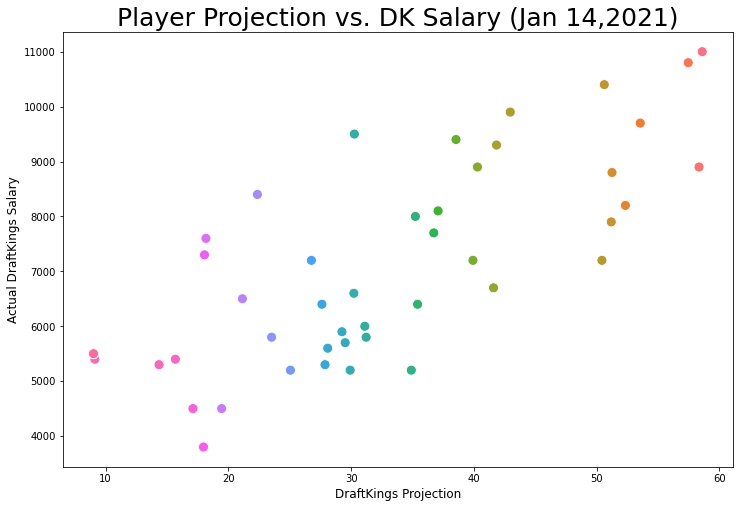

In [1160]:
plt.figure(figsize=(12,8))

sns.scatterplot(data=projections,x='DK_proj',y='Salary', hue='PLAYER  ',s=100, legend=False)

plt.xlabel('DraftKings Projection',size=12)
plt.ylabel('Actual DraftKings Salary',size=12)
plt.title('Player Projection vs. DK Salary (Jan 14,2021)', size=25)

Text(0.5, 1.0, 'Player Projection vs. DK Salary (Jan 14,2021)')

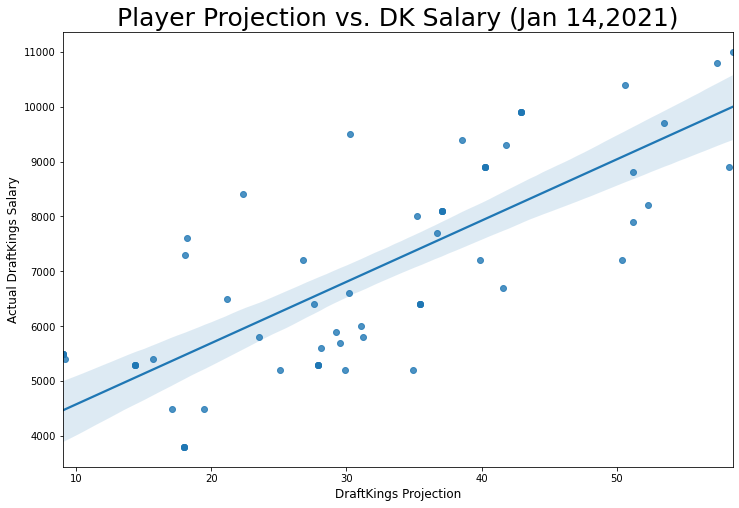

In [1161]:
plt.figure(figsize=(12,8))

sns.regplot(data=projections,x='DK_proj',y='Salary')

plt.xlabel('DraftKings Projection',size=12)
plt.ylabel('Actual DraftKings Salary',size=12)
plt.title('Player Projection vs. DK Salary (Jan 14,2021)', size=25)

## Optimizer to select optimal lineup

In [1162]:
# Code from Branko Blagojevic

# "Using Python and Linear Programming to Optimize Fantasy Football Picks"

import urllib, json
import pandas as pd
import re
from itertools import permutations

from pulp import *


projections = projections.rename(columns={'Position':'position',
                                          'PLAYER  ':'displayName',
                                          'Salary':'salary',
                                          'DK_proj':'points'})

guard = projections[projections['position'].isin(["PG","PG/SG","SG",'PG/SF','SG/SF'])].copy()
guard['position'] = 'guard'
projections = pd.concat([projections, guard])

forward = projections[projections['position'].isin(['PF','PF/C','PG/SF','SF','SF/PF','SG/SF'])].copy()
forward['position'] = 'forward'
projections = pd.concat([projections, forward])

util = projections[projections['position'].isin(['SG/SF', 'C', 'PG', 'PF', 'SF/PF', 'PF/C', 'PG/SG', 'SG', 'SF',
       'PG/SF'])].copy()
util['position'] = 'util'
projections = pd.concat([projections, util])


availables = projections[["position", "displayName", "salary",
  "points"]].groupby(["position", "displayName", "salary",
  "points"]).agg("count")
availables = availables.reset_index()


salaries = {}
points = {}
for pos in availables.position.unique():
    available_pos = availables[availables.position == pos]
    salary = list(available_pos[["displayName","salary"]].set_index("displayName").to_dict().values())[0]
    point = list(available_pos[["displayName","points"]].set_index("displayName").to_dict().values())[0]
    salaries[pos] = salary
    points[pos] = point
    
pos_num_available = {
    "PG": 1,
    'SG/SF':0,
    'SF/PF':0,
    "SG": 1,
    "C": 1,
    'PF': 1,
    'SF':1,
    'guard':1,
    'forward': 1,
    'util': 1,
    'PF/C':0,
    'PG/SG':0,
    'PG/SF':0
    }

SALARY_CAP = 50000

_vars = {k: LpVariable.dict(k, v, cat="Binary") for k, v in points.items()}

prob = LpProblem("Fantasy", LpMaximize)
rewards = []
costs = []
position_constraints = []

# Setting up the reward
for k, v in _vars.items():
    costs += lpSum([salaries[k][i] * _vars[k][i] for i in v])
    rewards += lpSum([points[k][i] * _vars[k][i] for i in v])
    prob += lpSum([_vars[k][i] for i in v]) <= pos_num_available[k]
    
prob += lpSum(rewards)
prob += lpSum(costs) <= SALARY_CAP

prob.solve()

def summary(prob):
    div = '---------------------------------------\n'
    print("Variables:\n")
    score = str(prob.objective)
    constraints = [str(const) for const in prob.constraints.values()]
    for v in prob.variables():
        score = score.replace(v.name, str(v.varValue))
        constraints = [const.replace(v.name, str(v.varValue)) for const in constraints]
        if v.varValue != 0:
            print(v.name, "=", v.varValue)
    print(div)
    print("Constraints:")
    for constraint in constraints:
        constraint_pretty = " + ".join(re.findall("[0-9\.]*\*1.0", constraint))
        if constraint_pretty != "":
            print("{} = {}".format(constraint_pretty, eval(constraint_pretty)))
    print(div)
    print("Score:")
    score_pretty = " + ".join(re.findall("[0-9\.]+\*1.0", score))
    print("{} = {}".format(score_pretty, eval(score)))
    
summary(prob)

Variables:

C_Christian_Wood = 1.0
PF_Lauri_Markkanen = 1.0
PG_Jrue_Holiday = 1.0
SG_Malik_Beasley = 1.0
forward_Draymond_Green = 1.0
guard_Malik_Beasley = 1.0
util_Malik_Beasley = 1.0
---------------------------------------

Constraints:
8900.0*1.0 + 6700.0*1.0 + 7200.0*1.0 + 7200.0*1.0 + 5200.0*1.0 + 7200.0*1.0 + 7200.0*1.0 = 49600.0
---------------------------------------

Score:
58.34*1.0 + 41.6*1.0 + 39.92*1.0 + 50.43*1.0 + 34.9*1.0 + 50.43*1.0 + 50.43*1.0 = 326.05


In [1104]:
_vars

{'C': {'Bam Adebayo': C_Bam_Adebayo,
  'Brook Lopez': C_Brook_Lopez,
  'Christian Wood': C_Christian_Wood,
  'Mason Plumlee': C_Mason_Plumlee,
  'Wendell Carter Jr.': C_Wendell_Carter_Jr.},
 'PF': {'Lauri Markkanen': PF_Lauri_Markkanen,
  'Robert Covington': PF_Robert_Covington},
 'PF/C': {'Anthony Davis': PF_C_Anthony_Davis,
  'Draymond Green': PF_C_Draymond_Green,
  'Giannis Antetokounmpo': PF_C_Giannis_Antetokounmpo,
  'John Collins': PF_C_John_Collins,
  'Kelly Olynyk': PF_C_Kelly_Olynyk,
  'LaMarcus Aldridge': PF_C_LaMarcus_Aldridge,
  'P.J. Tucker': PF_C_P.J._Tucker,
  'Pascal Siakam': PF_C_Pascal_Siakam},
 'PG': {'Damian Lillard': PG_Damian_Lillard,
  'Dejounte Murray': PG_Dejounte_Murray,
  'Jrue Holiday': PG_Jrue_Holiday,
  'Kyle Lowry': PG_Kyle_Lowry,
  'Luka Doncic': PG_Luka_Doncic,
  'Trae Young': PG_Trae_Young},
 'PG/SF': {'LeBron James': PG_SF_LeBron_James},
 'PG/SG': {'Coby White': PG_SG_Coby_White,
  'Delon Wright': PG_SG_Delon_Wright,
  'Dennis Schroder': PG_SG_Dennis_

In [1119]:
guard

,displayName,POS,points,Pts_proj,Reb_proj,Ast_proj,MSE_DK,MSE_Pts,MSE_Reb,MSE_Ast,salary,position,Cost_per_point
5,Luka Doncic,SF,58.60,25.65,16.67,9.44,300.28,71.88,39.69,16.01,11000.0,PG,187.71
8,James Harden,SG,57.46,36.19,4.83,6.10,224.81,126.58,9.02,9.98,10800.0,PG/SG,187.96
7,LeBron James,SF,53.55,26.74,8.31,8.37,104.25,39.92,10.17,11.26,9700.0,PG/SF,181.14
23,Fred VanVleet,PG,51.19,22.18,6.44,8.67,219.06,112.25,8.21,15.94,7900.0,PG/SG,154.33
33,Malik Beasley,SG,50.43,29.94,8.39,4.59,181.48,75.95,6.50,3.32,7200.0,SG,142.77
0,Damian Lillard,PG,42.96,23.56,4.43,7.26,223.38,125.99,4.81,9.92,9900.0,PG,230.45
2,Damian Lillard,PG,42.96,23.56,4.43,7.26,223.38,125.99,4.81,9.92,9900.0,PG,230.45
3,Damian Lillard,PG,42.96,23.56,4.43,7.26,223.38,125.99,4.81,9.92,9900.0,PG,230.45
1,Damian Lillard,PG,42.96,23.56,4.43,7.26,223.38,125.99,4.81,9.92,9900.0,PG,230.45
18,Jrue Holiday,PG,39.92,20.76,5.70,5.40,116.60,50.70,3.25,6.88,7200.0,PG,180.36
